# Table of Contents

0.  [Data Entry and Initialization](#dataentry)
0.  [Graph Display Functions](#graphfunctions)
0.  [First plot of the topology](#firstplot)
0.  [Calculating and Plotting Dijkstra Paths](#dijkstra)
0.  [Calculating Maximum Flow Rates](#maxflow)
    0.  [Single Source and Dest Pair](#singlemaxflow)
0.  [Adding Schedular] (#schedule)

# First Order Analysis

This notebook performs simple first order calculations based on a network topology graph, link capacity, edge capacity and campus nodes to represent sources and sinks for network traffic.  Some of the first order techniques include running optimization and allocation algorithms on network traffic paths, based on topology and demand.  This notebook is a prototype for learning how to work with NetworkX, matplotlib and other tools in order to do first order analysis.  The learning from this scratchpad space is used to implemnet a set of python modules that provide concise access to the variety of functions prototyped here.  The python library can be used for proper and concise implementations of FOA, without the verbosity of this sandbox.

<a id=dataentry> </a>
## Data Entry and Initialization


The simplest form of data entry for the first order model is a tab separated file, that contains nodes, links and bw.

In [2]:

import csv
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np

G  = nx.DiGraph()

pos = {}
node_label_pos = {}


with open('esnet6_proposed_footprint.txt') as f:
    reader = csv.DictReader(f , delimiter='\t')
            
    for row in reader :
        
        pos[row['SITE']]=(int(row['X']) , int(row['Y']))
        node_label_pos[row['SITE']] = (pos[row['SITE']][0] + 3 , pos[row['SITE']][1] + 3)

        G.add_node(row['SITE'] , SITE=row['SITE'],PE=float(row['PE']), X=pos[row['SITE']][0], Y=pos[row['SITE']][1], 
                   Xlbl=node_label_pos[row['SITE']][0], Ylbl=node_label_pos[row['SITE']][1])

        total_bw = 0;
        if (row['LINK1'] is not None): 
            G.add_edges_from([ (row['SITE'] , row['LINK1']) , (row['LINK1'] , row['SITE']) ],
                       capacity=float(row['LINK1BW']) , 
                       impedance=1/(float(row['LINK1BW']))
                      )
            total_bw += float(row['LINK1BW'])

        if (row['LINK2'] is not None): 
            G.add_edges_from([ (row['SITE'] , row['LINK2']) , (row['LINK2'] , row['SITE']) ],
                       capacity=float(row['LINK2BW']) ,
                       impedance=1/(float(row['LINK2BW']))                       
                      )
            total_bw += float(row['LINK2BW'])
            
        if (row['LINK3'] is not None): 
            G.add_edges_from([ (row['SITE'] , row['LINK3']) , (row['LINK3'] , row['SITE']) ],
                       capacity=float(row['LINK3BW']) ,
                       impedance=1/(float(row['LINK3BW']))                       
                      ) 
            total_bw += float(row['LINK3BW'])
            
        if (row['LINK4'] is not None): 
            G.add_edges_from([ (row['SITE'] , row['LINK4']) , (row['LINK4'] , row['SITE']) ],
                       capacity=float(row['LINK4BW']) ,
                       impedance=1/(float(row['LINK4BW']))                       
                      )  
            total_bw += float(row['LINK4BW'])    

        G.node[row['SITE']]['bw'] = total_bw
        G.node[row['SITE']]['type'] = row['TYPE']
#         nx.set_node_attributes(G,'bw',{row['SITE']:total_bw})
#         nx.set_node_attributes(G,'type',{row['SITE']:row['TYPE']})        

types = nx.get_node_attributes(G,'type')
end_sites  = [ k for k,v in types.items() if v == 'S']
core_sites = [ k for k,v in types.items() if v == 'C']        

CG = G.copy()
CG.remove_nodes_from(end_sites)
nx.write_graphml(G,'network.graphml', prettyprint=True)

#--------------------------------------------------------------
# calculate some global variables that can be used at any time
# in order to determine node and edge sizes based on capacity
#--------------------------------------------------------------

edges = G.edges()
link_bw = nx.get_edge_attributes(G,'capacity')
print(edges)
print(G.nodes())

[('SEAT', 'BOIS'), ('SEAT', 'SACR'), ('BOIS', 'SEAT'), ('BOIS', 'SALT'), ('SACR', 'SEAT'), ('SACR', 'SALT'), ('SACR', 'SNLL'), ('SACR', 'JGI'), ('ANL-1', 'FNAL-1'), ('ANL-1', 'ANL-2'), ('FNAL-1', 'ANL-1'), ('FNAL-1', 'FNAL-2'), ('ANL-2', 'ANL-1'), ('ANL-2', 'STAR'), ('STAR', 'ANL-2'), ('STAR', 'CHIC'), ('STAR', 'EQCH'), ('STAR', 'NASH'), ('STAR', 'UMCH'), ('STAR', 'IU'), ('STAR', 'PURD'), ('STAR', 'UWIS'), ('BOST', 'CLEV'), ('BOST', 'NEWY'), ('BOST', 'UMIT'), ('BOST', 'BU'), ('BOST', 'HU'), ('CLEV', 'BOST'), ('CLEV', 'EQCH'), ('CLEV', 'ASHB'), ('NEWY', 'BOST'), ('NEWY', 'BNL-1'), ('NEWY', 'AOFA'), ('FNAL-2', 'FNAL-1'), ('FNAL-2', 'CHIC'), ('CHIC', 'FNAL-2'), ('CHIC', 'STAR'), ('CHIC', 'KANS'), ('KANS', 'CHIC'), ('KANS', 'HOUS'), ('KANS', 'DENV'), ('KANS', 'UNEB'), ('KANS', 'OKLH'), ('HOUS', 'KANS'), ('HOUS', 'ATLA'), ('HOUS', 'ELPA'), ('HOUS', 'UTXA'), ('DENV', 'KANS'), ('DENV', 'SALT'), ('DENV', 'ALBQ'), ('EQCH', 'STAR'), ('EQCH', 'CLEV'), ('ASHB', 'CLEV'), ('ASHB', 'WASH'), ('WASH', 

<a id=graphfunctions> </a>
## Graph Display Functions
### drawBaseMap()

This function draws the topology map as a faded background image by default.  It is intended to be overlayed with other drawing functions that hightlight nodes and edges to demonstrate flows or interesting network nodes.  

### highlightNodes()

This function can be used to overlay a single or more subset of nodes with their own display characteristics in order to have them stand out on the base map.


In [3]:
NodeSizeFactor  = 100    #  NodeSize = BW in Tbits per second x NodeSizeFactor 
EdgeWidthFactor = 4      #  EdgeWidth = BW in Tbits per second x EdgeWidthFactor


#----------------------------------------------------------------------
# Shortcut functions to draw maps.  Sometimes they use global variables
# for expediancy.  
#----------------------------------------------------------------------
    
def drawBaseMap(G , node_color='grey' , edges=True , alpha=0.5 , arrows=False , campus=True) :

    types = nx.get_node_attributes(G,'type')
    end_sites  = [ k for k,v in types.items() if v == 'S']
    core_sites = [ k for k,v in types.items() if v == 'C']
    
    bw = nx.get_node_attributes(G,'bw')
    pe = nx.get_node_attributes(G,'PE')
       
    bw_size = [ NodeSizeFactor * bw[site] for site in core_sites ]
    nx.draw_networkx_nodes(G , nodelist=core_sites, pos=pos , node_size=bw_size , 
                           node_color='white', edgecolors='black',alpha=alpha)

    if campus :
        pe_size = [ NodeSizeFactor * pe[site] for site in end_sites ]
        nx.draw_networkx_nodes(G , nodelist=end_sites,  pos=pos , node_size=pe_size , 
                               node_color='lightblue', edgecolors='black', alpha=alpha)

    pe_size = [ NodeSizeFactor * pe[site] for site in core_sites ]    
    nx.draw_networkx_nodes(G , nodelist=core_sites, pos=pos , node_size=pe_size , 
                           node_color=node_color, edgecolors='black' , alpha=alpha)

    nx.draw_networkx_labels(G , pos=node_label_pos , font_size=10)
    
    if (edges) : 
        if (arrows) : 
            width = [EdgeWidthFactor*link_bw[e] for e in G.edges()]            
            nx.draw_networkx_edges (G , pos=pos, width=width, edge_color='lightgrey', alpha=alpha)
        else :
            width = [5*link_bw[e] for e in G.edges()]
            nx.draw_networkx_edges (G , pos=pos, width=width, edge_color='lightgrey', alpha=alpha , arrows=False)  
        
        edge_bw = nx.get_edge_attributes(G,'capacity')
        nx.draw_networkx_edge_labels(G , pos=pos, edge_labels=edge_bw, label_pos=0.75, 
                                     edge_color='lightgrey', font_size=9, alpha=alpha)


def highlightNodes(G , nodelist=None , node_color='red' , alpha=0.5 , node_shape='o') :
    if (not nodelist) : nodelist = G.nodes()
    nx.draw_networkx_nodes(G , pos=pos , nodelist=nodelist , 
                           node_size=[1200 , 1200] , 
                           node_color=node_color, edgecolors='black',
                           alpha=alpha , node_shape=node_shape)

def hightlightEdges( G , edgelist=None , edge_color='red' , font_weight='normal', rate=0.1 , alpha=0.5, labels=False) :

    if (not edgelist) : edgelist = G.edges()

    if isinstance(rate,dict):
        width = [EdgeWidthFactor*rate[e] for e in edgelist]
    elif isinstance(rate,list) :
        width = rate
    else :
        width = EdgeWidthFactor*rate
        
    nx.draw_networkx_edges (G , pos=pos, 
                                   edgelist=edgelist, 
                                   edge_color=edge_color,
                                   width=width , 
                                   alpha = alpha ,
                                   arrowstyle='simple'
                            )
    edge_labels = {}
    if labels :
        if isinstance(rate, dict):
            edge_labels = rate
        else :
            for edge in edgelist : edge_labels[edge] = rate

        nx.draw_networkx_edge_labels(G , edgelist=edgelist, pos=pos, edge_labels=edge_labels, label_pos=0.5, 
                                     font_color=edge_color, font_weight=font_weight, font_size=9, alpha=alpha)

def highlightEdgeVector(G,pos,edgelist=False,distance=[-0.5 , -0.25 , 0.25 , 0.5 ] , 
                        tail=0.2 , head = 0.2 , edge_color='black', width=1 , alpha = 1 ,
                        style='tapered'
                       ):
    
    import math
    from math import cos
    from math import sin
    from math import pi
    
    def rotate(p , theta) :
        x = p[0]
        y = p[1]
        x1 =  x*cos(theta) + y*sin(theta)
        y1 = -x*sin(theta) + y*cos(theta)
        return (x1,y1)
    
    for delta in distance :
        if (edgelist == False) : edgelist = G.edges()
        for edge in edgelist :
            s = edge[0]
            t = edge[1]
            
            spos = pos[s]
            tpos = pos[t]

            spost = (0,0)
            tpost = (tpos[0] - spos[0],tpos[1]-spos[1])
            
            theta = math.acos( abs(tpost[0] - spost[0]) / math.sqrt((tpost[0]-spost[0])**2 + (tpost[1]-spost[1])**2) )


            if ((tpost[0] > spost[0]) & (tpost[1] < spost[1]))   : sgn = -1 
            elif ((tpost[0] < spost[0]) & (tpost[1] > spost[1])) : sgn = -1 
            else : sgn = 1

            theta = theta * sgn
            
            srpos = rotate(spost,theta)
            trpos = rotate(tpost,theta)

            if (srpos[0] > trpos[0]) : sgn = -1
            else :                     sgn = 1

            srpos = (srpos[0] + sgn*abs(tail) , srpos[1] + delta)
            trpos = (trpos[0] - sgn*abs(head) , trpos[1] + delta)

            spos1 = rotate(srpos,-theta)
            tpos1 = rotate(trpos,-theta)
 
            new_pos={}
            if (style == 'tapered') :
                new_pos[s] = spos
            else :
                new_pos[s] = (spos1[0]+spos[0],spos1[1]+spos[1])
                
            new_pos[t] = (tpos1[0]+spos[0],tpos1[1]+spos[1])
        
            nx.draw_networkx_edges(G,pos=new_pos , edgelist=[(s,t)] , width=width , edge_color=edge_color , alpha=alpha)   





<a id=firstplot> </a>
## First plot of the topology 

Simple plot of the topology and capacity based on the model that was read in from the external CSV file.  Edge widths are scaled with bandwidth.  The graph is a diGraph, however for clarity it displays with simple edges.

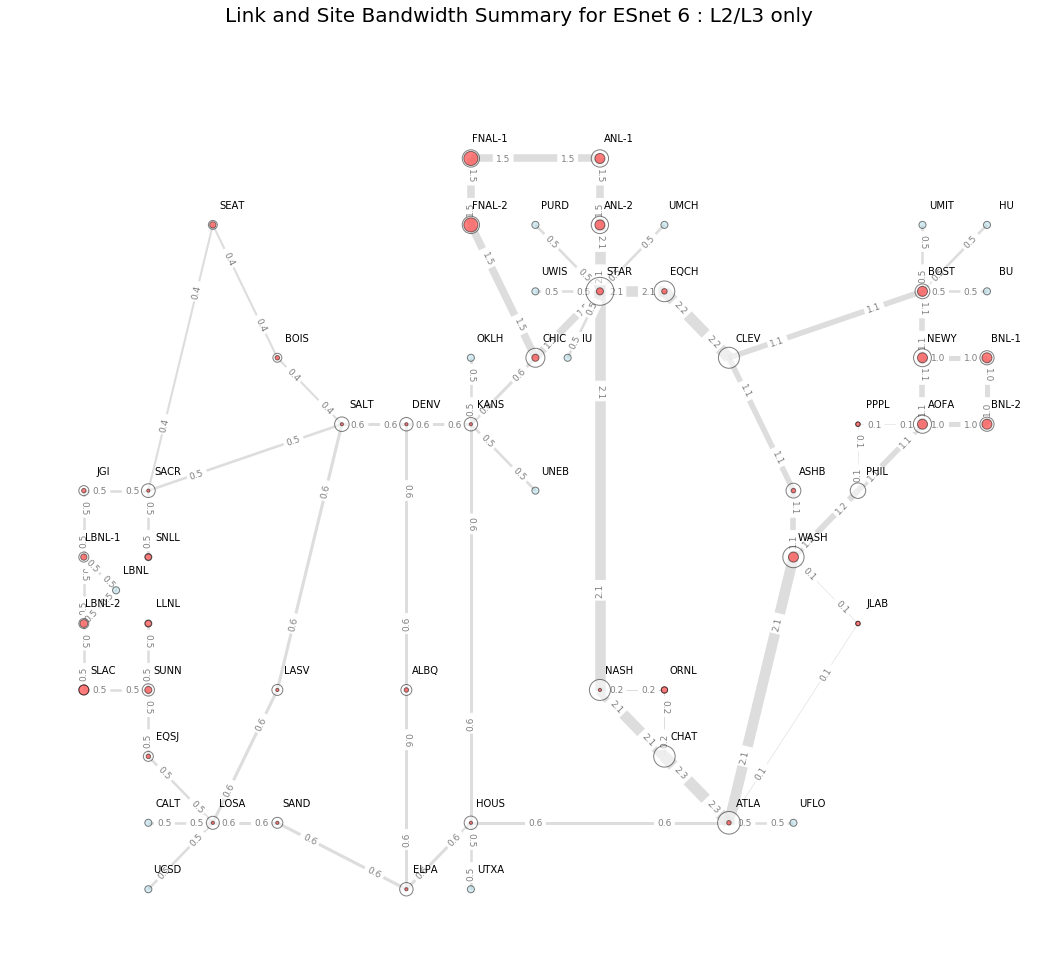

In [4]:
fig = plt.figure(figsize=(18,15))
plt.axis('off')

#drawBaseMap(CG , node_color='yellow' , arrows=False , alpha=0.5 )
drawBaseMap(G  , node_color='red' , arrows=False , alpha=0.5 )

fig.suptitle('Link and Site Bandwidth Summary for ESnet 6 : L2/L3 only', fontsize=20)

plt.show()

<a id=dijkstra> </a>
## Calculating and Plotting Dijkstra Paths

In [5]:
# paths_from_slac = nx.single_source_shortest_path(G,'SLAC')

dijkstra_source = 'BNL-2'
paths_from_dijkstra = nx.single_source_dijkstra_path(G,dijkstra_source,weight='impedance')

dijkstra_dest = 'LBNL'
aPath = paths_from_dijkstra[dijkstra_dest]
path_edges = list(zip(aPath,aPath[1:]))

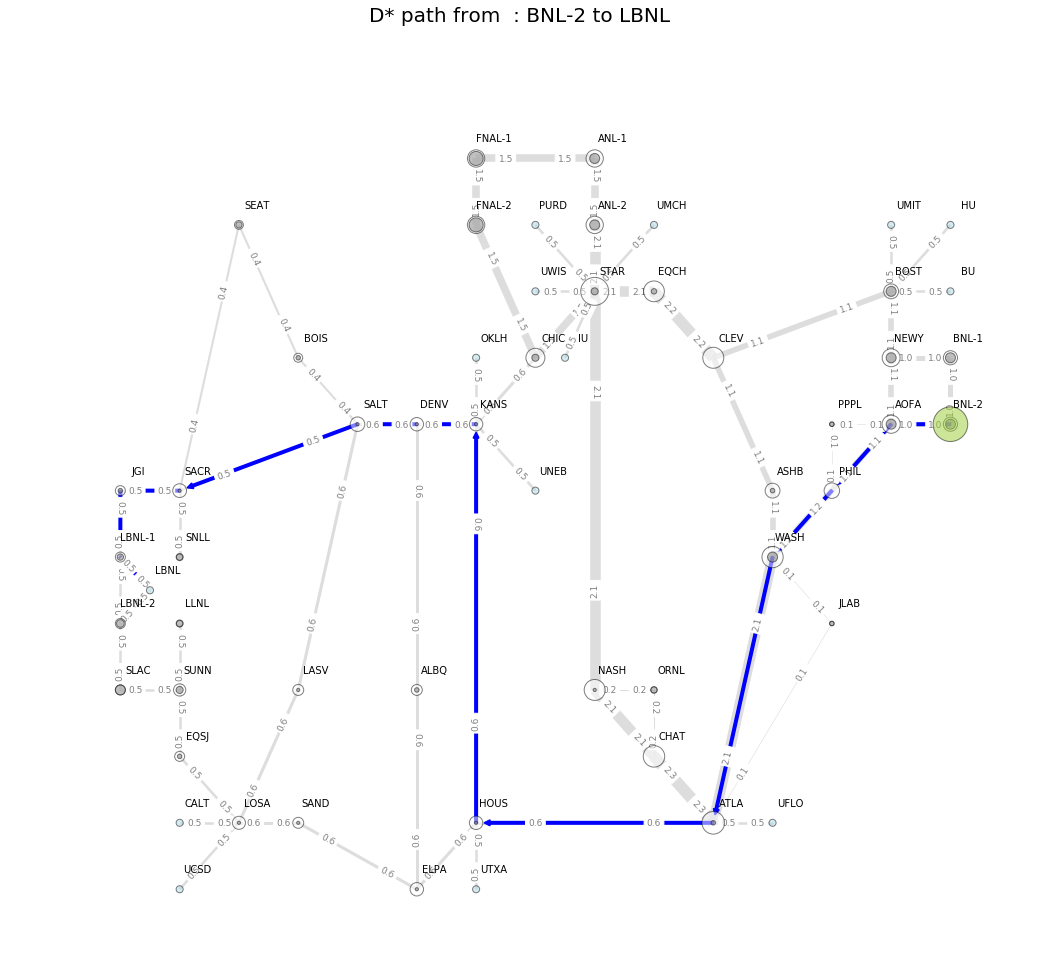

In [7]:
fig = plt.figure(figsize=(18,15))
plt.axis('off')
drawBaseMap(G)

fig.suptitle('D* path from  : ' + dijkstra_source + " to " + dijkstra_dest, fontsize=20)
#nx.draw_networkx_edges (G , pos=pos, edgelist=path_edges   , edge_color='r', width=4 , arrows='true')
hightlightEdges( G , edgelist=path_edges , edge_color='blue' , font_weight='bold' , rate=0.5 , alpha=1, labels=False) 
highlightNodes(G , nodelist=[dijkstra_source] , node_color='yellowgreen' , alpha=0.5 , node_shape='o')
plt.show()

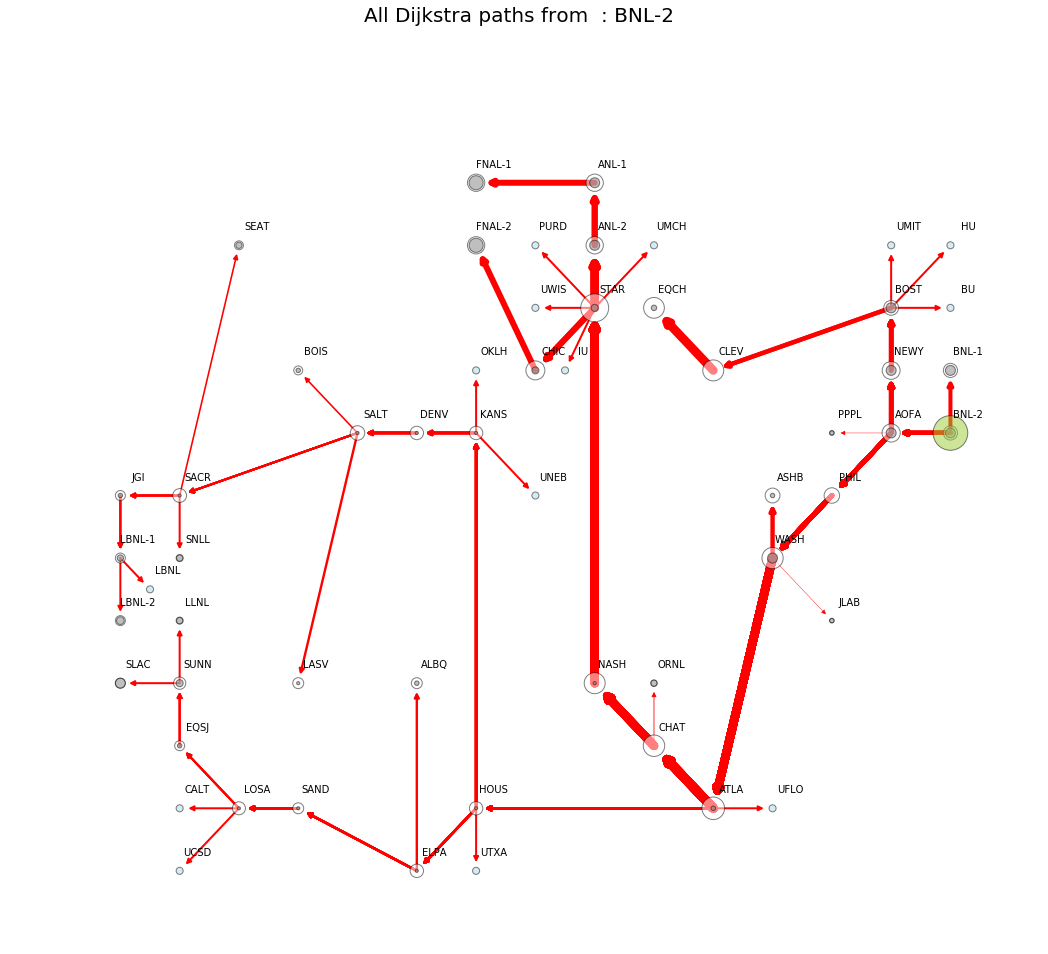

In [6]:
fig = plt.figure(figsize=(18,15))
plt.axis('off')
#plt.tight_layout()
drawBaseMap(G,edges=False)

# Mark the dijkstra start node in it's own colour

highlightNodes(G , nodelist=[dijkstra_source] , node_color='yellowgreen' , alpha=0.5 , node_shape='o')

for aDest in paths_from_dijkstra :
    aPath = paths_from_dijkstra[aDest]
    path_edges = list(zip(aPath,aPath[1:]))
    dijkstra_e_width = []
    for e in path_edges :
        dijkstra_e_width.append(EdgeWidthFactor*link_bw[e])

    nx.draw_networkx_edges (G , pos=pos, edgelist=path_edges, edge_color='red', width=dijkstra_e_width )
    
fig.suptitle('All Dijkstra paths from  : ' + dijkstra_source, fontsize=20)
    
plt.show() 

<a id=maxflow> </a>
## Calculating Maximum Flow Rates
<a id=singlemaxflow> </a>
###  Single Source and Dest Pair

In [7]:
from networkx.algorithms.flow import shortest_augmenting_path
from networkx.algorithms.flow import edmonds_karp

flow_source = 'BNL-2'
all_flows = {}
for site in end_sites:
    flow_dest = site
    flow_rate , flows = nx.maximum_flow(G, flow_source, flow_dest , flow_func=shortest_augmenting_path)
    all_flows[(flow_source,flow_dest)] = flows

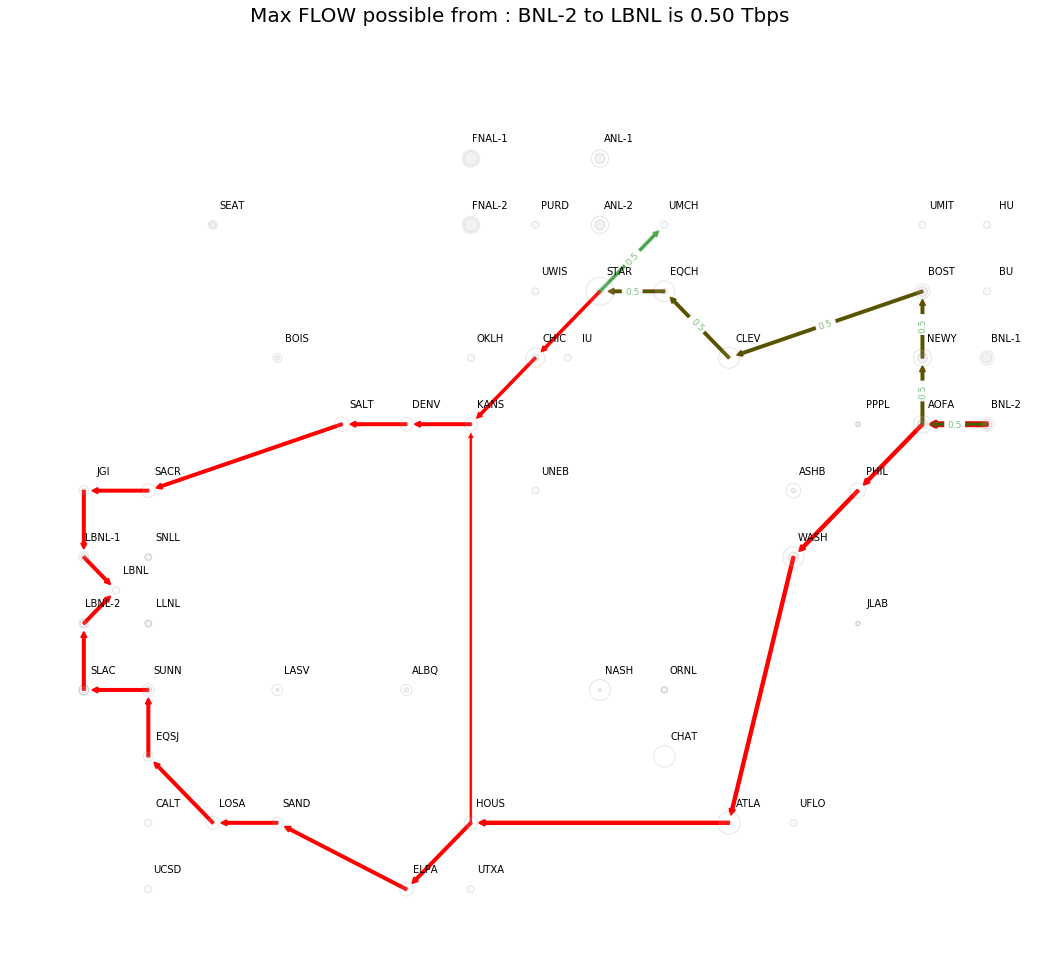

In [8]:

fig = plt.figure(figsize=(18,15))
plt.axis('off')
fig.suptitle('Max FLOW possible from : ' + flow_source + " to " + flow_dest + " is %2.2f Tbps" % flow_rate, fontsize=20)

drawBaseMap(G,alpha=0.1,edges=False)   # Draw the background image of the network
#highlightNodes(G , nodelist=[flow_source, flow_dest], node_color=['yellowgreen','purple'])

# Plot the FLOW paths.  See nx.maximum_flows() to understand the "flows" datastructure.


flow_dest = 'LBNL'
flows = all_flows[(flow_source,flow_dest)]

for site , links in flows.items() :
    for link , rate in links.items() :
        if (rate > 0) :
            hightlightEdges(G , edgelist=[(site,link)] , rate=rate ,  alpha=1)
            
fig.suptitle('Max FLOW possible from : ' + flow_source + " to " + flow_dest + " is %2.2f Tbps" % flow_rate, fontsize=20)

flow_dest = 'UMCH'            
flows = all_flows[(flow_source,flow_dest)]

for site , links in flows.items() :
    for link , rate in links.items() :
        if (rate > 0) :
            hightlightEdges(G , edgelist=[(site,link)] , rate=rate ,  alpha=0.5 , edge_color='green' , labels=True)
                    
            
plt.show()

In [9]:
nodelist = list(G.nodes())
m = nx.attr_matrix(G , edge_attr='capacity' , rc_order=nodelist)
print(m)

[[0.  0.4 0.4 ... 0.  0.  0. ]
 [0.4 0.  0.  ... 0.  0.  0. ]
 [0.4 0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


In [10]:
m = m * 10.0
print (nodelist)
print (nodelist[0],m[0])
print (nodelist[15],m[15])

['SEAT', 'BOIS', 'SACR', 'ANL-1', 'FNAL-1', 'ANL-2', 'STAR', 'BOST', 'CLEV', 'NEWY', 'FNAL-2', 'CHIC', 'KANS', 'HOUS', 'DENV', 'EQCH', 'ASHB', 'WASH', 'PHIL', 'JLAB', 'ATLA', 'NASH', 'PPPL', 'AOFA', 'SALT', 'LASV', 'ALBQ', 'BNL-1', 'BNL-2', 'SNLL', 'JGI', 'LLNL', 'SUNN', 'LOSA', 'LBNL-1', 'LBNL-2', 'ORNL', 'CHAT', 'SLAC', 'EQSJ', 'ELPA', 'SAND', 'CALT', 'UFLO', 'UMCH', 'LBNL', 'UMIT', 'IU', 'UNEB', 'BU', 'HU', 'PURD', 'OKLH', 'UTXA', 'UWIS', 'UCSD']
SEAT [[0. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
EQCH [[ 0.  0.  0.  0.  0.  0. 21.  0. 22.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]


In [11]:
df       = pd.DataFrame(flows)
df.fillna(0,inplace=True)
df_rates = pd.DataFrame(m)
df.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
df_rates.values

array([[0., 4., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
#pd.read_csv('esnet6_proposed_footprint.txt' , sep='\t')

In [14]:
from scipy import optimize

paths = np.matrix([[ 0 , 0, 1, 0, 0, 1, 0, 1],
                   [ 0 , 1, 0, 0, 1, 1, 1, 0]]
                  )
flows = np.matrix([0.5,2.0])
links = np.matrix([1.0, 1.0, 1.0 , 1.0, 2.0, 2.0, 2.0, 2.0])

transfer_workload = [{('FNAL-1','UCSD') : 1.0} , 
                     {('BNL-1','UCSD')  : 1.0} 
                    ]


In [15]:
from operator import mul

def make_objective(c) :
    return lambda x : sum([(c[i]-x[i])**2 for i in range(len(x))])

def make_constraint(m,f) :
    return lambda x : m - sum(map(mul,x,f))

def make_src_rates(t) :
    return [1.0,2.0]

def make_bounds() :
    return (0.0,2.0)

bnd = (0.0,2.0)
bounds = (bnd,bnd)           # later this can be per link min - max
src_max_rates = [1.0, 2.0]   # later this can be per site transfer rate

objective = make_objective(src_max_rates)  # mean squares objective function

constraints = []

constraints.append(make_constraint(2.5, [1.0,1.0]))
constraints.append(make_constraint(1.5, [1.0,0.0]))
constraints.append(make_constraint(1.5, [0.0,1.0]))

opt_result = optimize.fmin_slsqp(objective,[0.1,0.1],
                                 bounds=bounds, 
                                 ieqcons=constraints, 
                                 full_output=1)
print (opt_result)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.25
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
(array([1. , 1.5]), 0.25, 2, 0, 'Optimization terminated successfully.')


<a id=schedule> </a>
## Adding a schedule for transfers




In [16]:
import json

transferstore=json.loads(open('transfersdb.json').read())

print(transferstore)


{'transfers': [{'src': 'STAR', 'dest': 'SUNN', 'starttime': 2, 'duration': 2}, {'src': 'DENV', 'dest': 'NASH', 'starttime': 2, 'duration': 10}, {'src': 'WASH', 'dest': 'STAR', 'starttime': 6, 'duration': 5}]}


In [17]:
transfersz=transferstore["transfers"].__len__()

i=0
while i<transfersz:
    print(transferstore["transfers"][i]["src"])
    print(transferstore["transfers"][i]["dest"])
    i+=1


STAR
SUNN
DENV
NASH
WASH
STAR


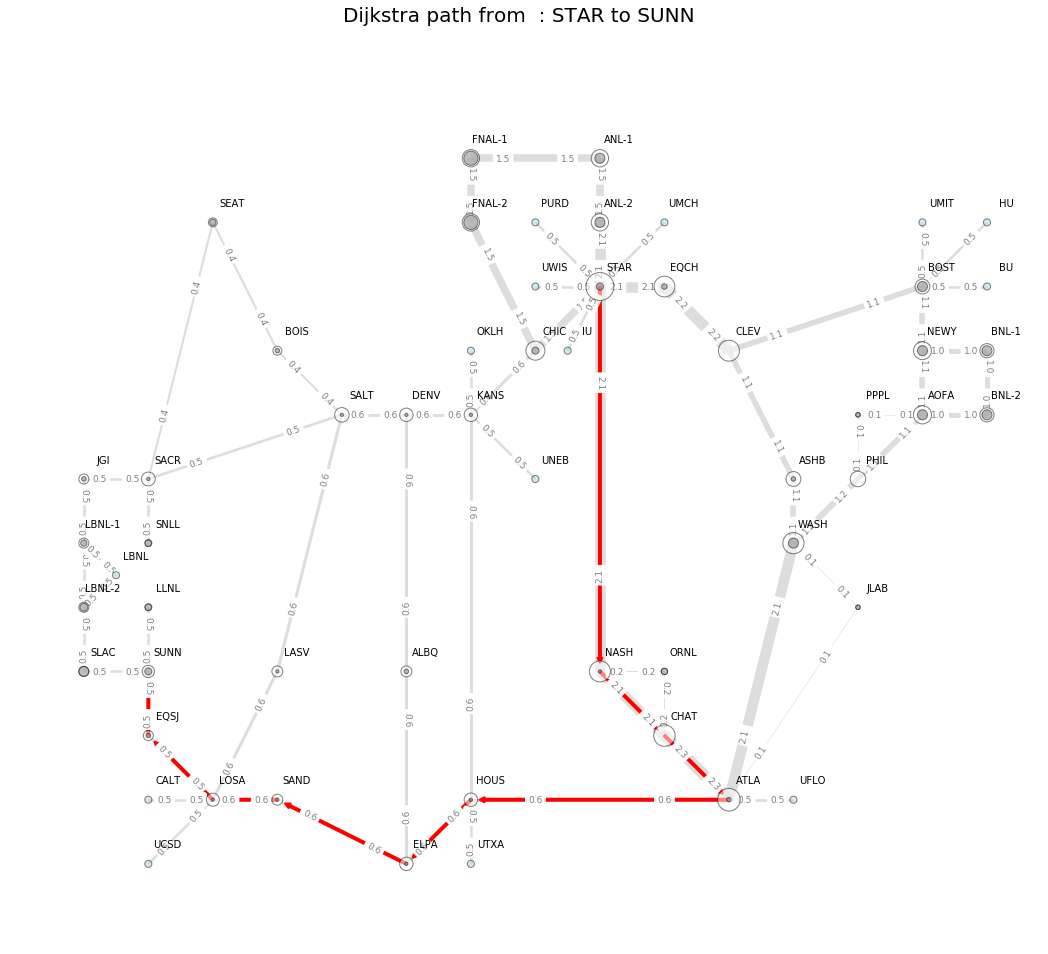

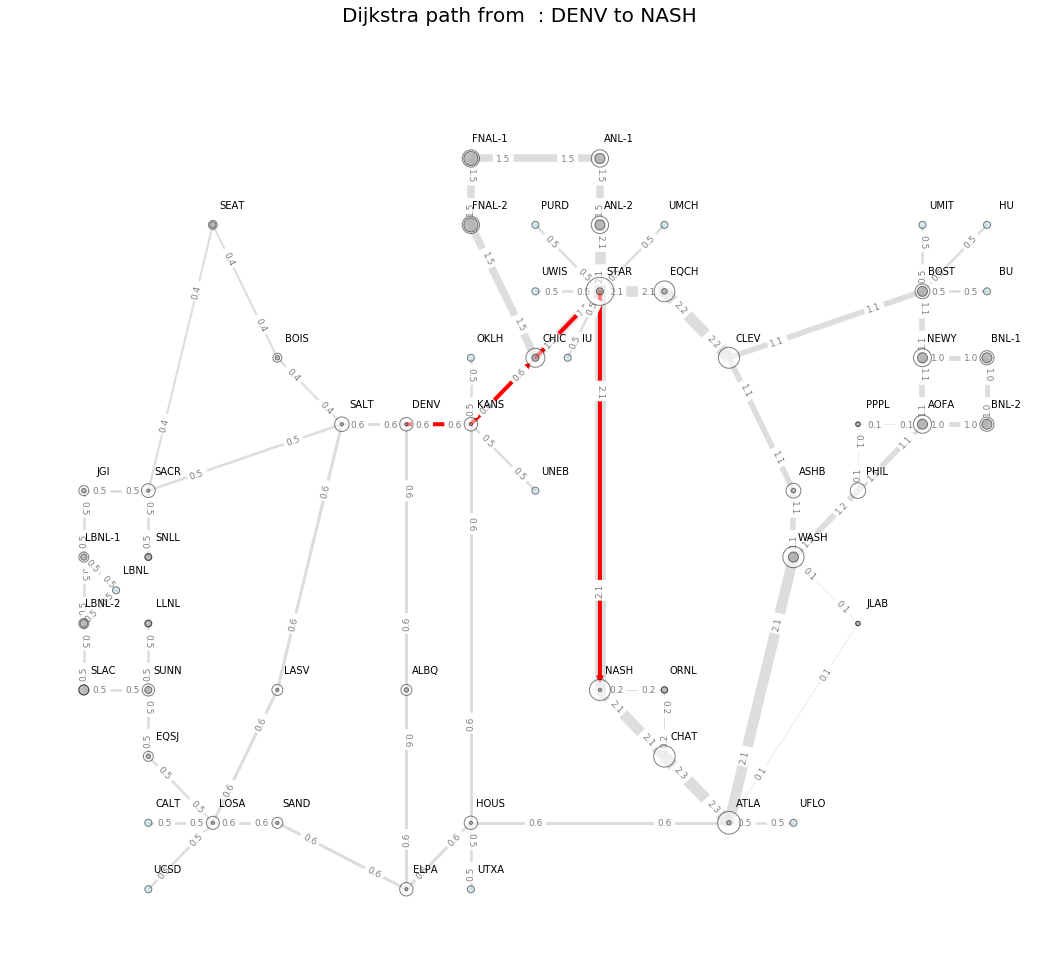

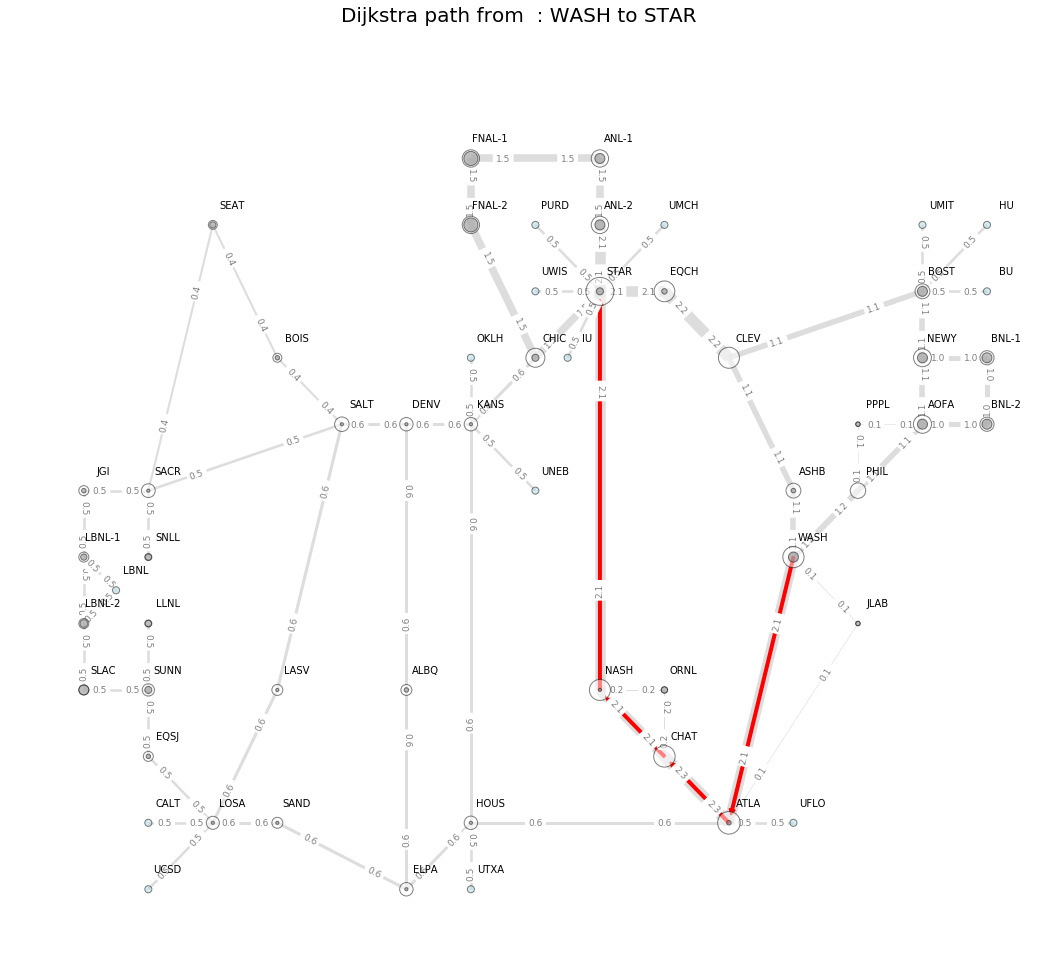

In [18]:

# plot all paths active at time t=0
transfersz=transferstore["transfers"].__len__()

i=0
while i<transfersz:
    source= transferstore["transfers"][i]["src"]
    destination= transferstore["transfers"][i]["dest"]
    paths_from_dijkstra = nx.single_source_dijkstra_path(G,source,weight='impedance')
    aPath = paths_from_dijkstra[destination]
    path_edges = list(zip(aPath,aPath[1:]))
    fig = plt.figure(figsize=(18,15))
    plt.axis('off')
    drawBaseMap(G)
    i+=1
    fig.suptitle('Dijkstra path from  : ' + source + " to " + destination, fontsize=20)
    hightlightEdges( G , edgelist=path_edges , edge_color='red' , font_weight='bold' , rate=0.5 , alpha=1, labels=False) 
    plt.axis('off')
    plt.show()
    


    

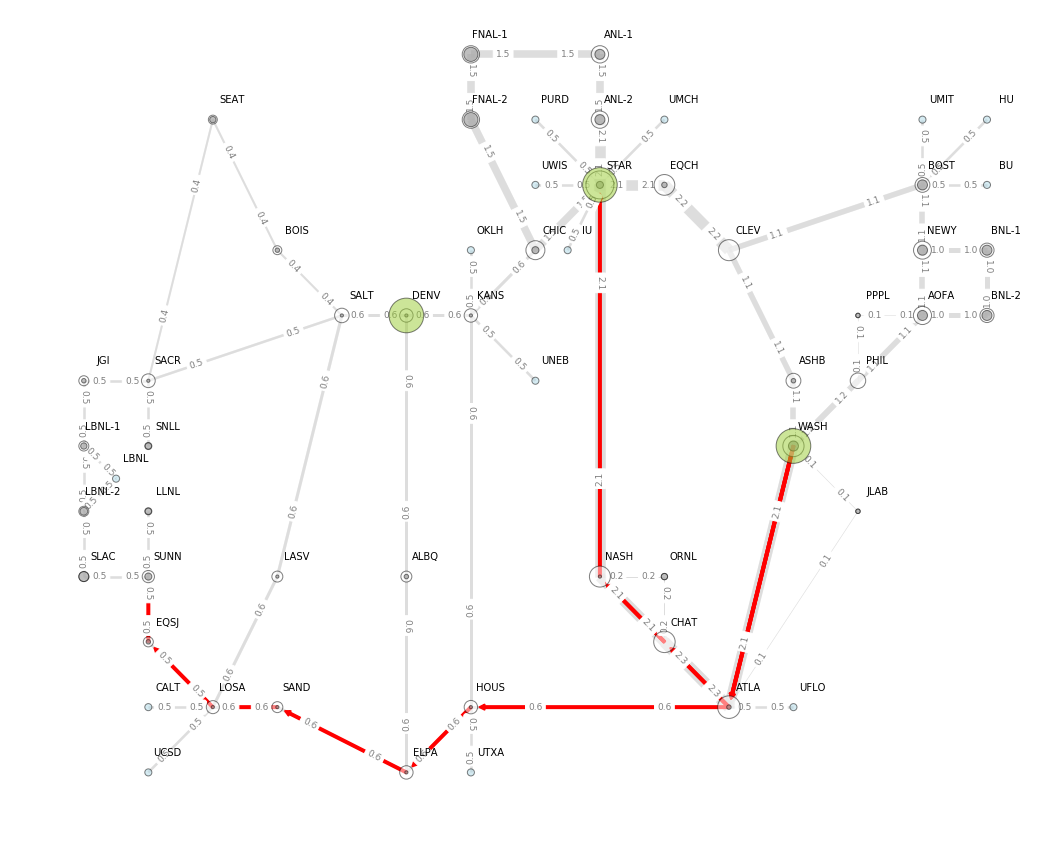

In [19]:
fig = plt.figure(figsize=(18,15))
plt.axis('off')
#plt.tight_layout()
drawBaseMap(G,edges=True)

# Mark all start nodes
i=0
while i<transfersz:
    source= transferstore["transfers"][i]["src"]
    highlightNodes(G , nodelist=[source] , node_color='yellowgreen' , alpha=0.5 , node_shape='o')
   
    destination = transferstore["transfers"][i]["dest"]
    aPath = paths_from_dijkstra[destination]
    path_edges = list(zip(aPath,aPath[1:]))
    hightlightEdges(G , edgelist=path_edges , edge_color='red' , font_weight='bold' , rate=0.5 , alpha=1, labels=False) 
    i+=1
   
plt.show() 